2023-10-16 21:16:58.076226: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 21:17:03.039070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0


2023-10-16 21:17:07.300729: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x559286f31b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 21:17:07.300797: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-10-16 21:17:07.373551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 21:17:07.483165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-10-16 21:17:07.838066: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0, Loss: 0.05729052424430847
Epoch 10, Loss: 0.054066676646471024
Epoch 20, Loss: 0.051963746547698975
Epoch 30, Loss: 0.04954574257135391
Epoch 40, Loss: 0.04772157594561577
Epoch 50, Loss: 0.046122293919324875
Epoch 60, Loss: 0.0438697375357151
Epoch 70, Loss: 0.041788630187511444
Epoch 80, Loss: 0.03991822153329849
Epoch 90, Loss: 0.03809120133519173
Epoch 100, Loss: 0.036205124109983444
Epoch 110, Loss: 0.0345485620200634
Epoch 120, Loss: 0.03328729048371315
Epoch 130, Loss: 0.0314481295645237
Epoch 140, Loss: 0.030047576874494553
Epoch 150, Loss: 0.028561044484376907
Epoch 160, Loss: 0.027197815477848053
Epoch 170, Loss: 0.025579050183296204
Epoch 180, Loss: 0.02438190206885338
Epoch 190, Loss: 0.02293781004846096
Epoch 200, Loss: 0.02173285186290741
Epoch 210, Loss: 0.020571958273649216
Epoch 220, Loss: 0.01936359331011772
Epoch 230, Loss: 0.01828763261437416
Epoch 240, Loss: 0.016911284998059273
Epoch 250, Loss: 0.016023961827158928
Epoch 260, Loss: 0.014985531568527222
Ep

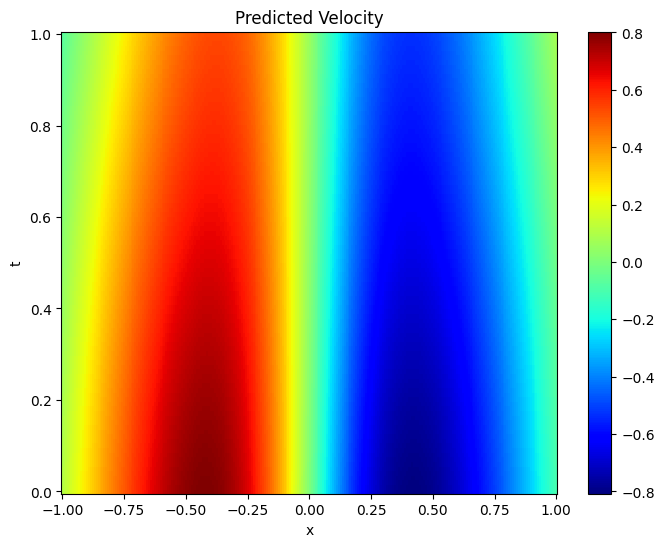

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch: 499


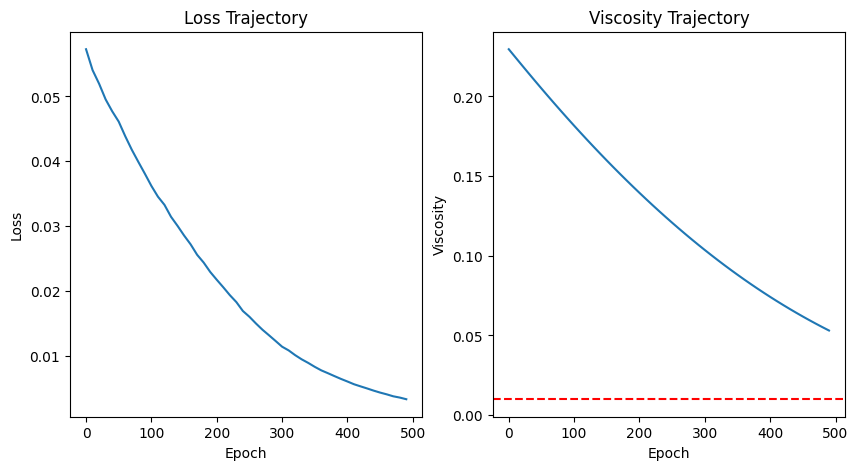

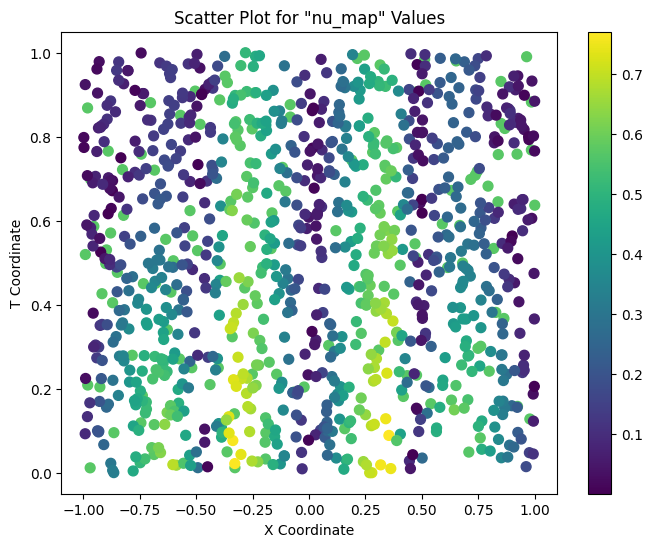

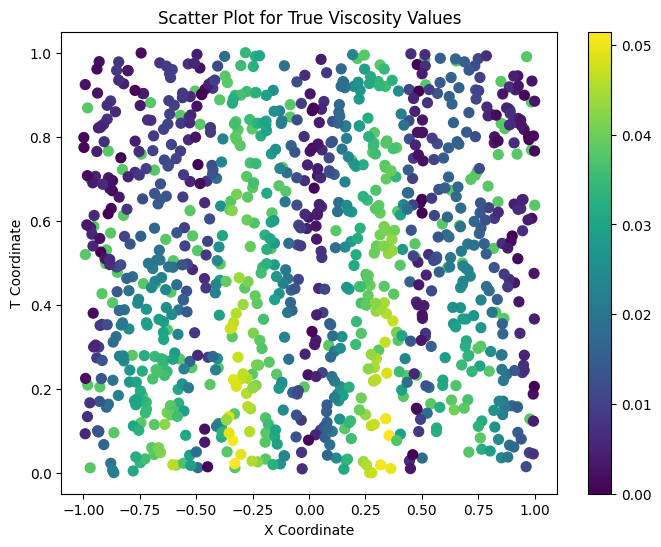

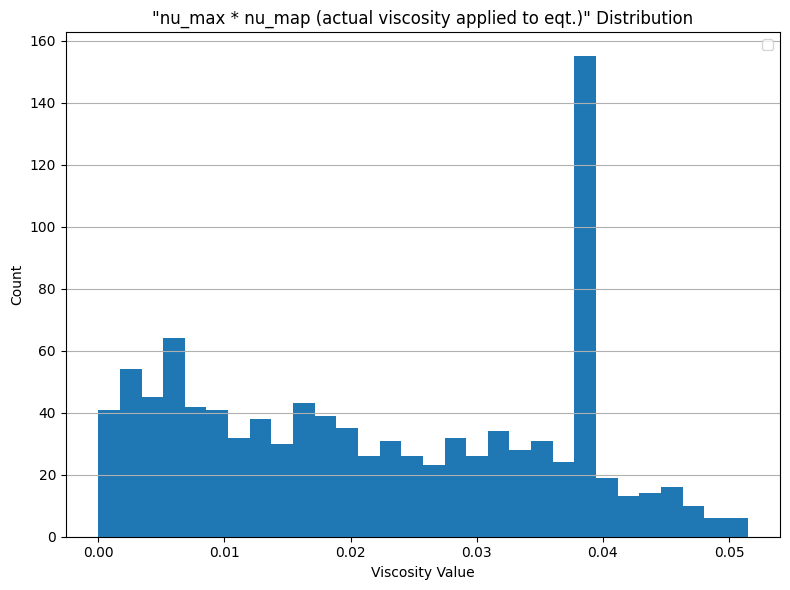

nu_max:  <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.05126973>


In [1]:
# v16 16 Oct 2023 
# artificial viscosity - achieved with TF variables
# made adjustment on IC/BC loss functions

## parametric method:
# ###### the shock width decreases with time ###### and loss and nu_max trajectory shows reasonable.
# However the theta_map and nu_map show random values all over the place without the "Gaussian distribution"
# Designate the Gaussian distribution over the viscosity map
# Include t_shock and std_dev as part of the learnable variables

## Residual-based AV method:
# revise from 11 Oct_v2 para AV


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

# data = scipy.io.loadmat('burgers_shock.mat')
# Exact = data['usol']
# Exact_u = np.real(Exact)

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=tf.ones([]) * viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

def maxmin_loc(x, t, data, type):
    # Define the number of surrounding points you want to extract
    num_surrounding_points = 100

    # Loop through each collocation point
    for i in range(domain.batch_size_0):
        x_collocation = x[i]
        t_collocation = t[i]

        # Calculate the squared distances between all collocation points and the target point
        squared_distances = tf.square(x - x_collocation) + tf.square(t - t_collocation)

        # Find the indices of the nearest points
        nearest_indices = tf.argsort(squared_distances)[:num_surrounding_points]

        # Extract the values at those indices
        surrounding_values = tf.gather(data, nearest_indices)

        if type == "max":
            # Calculate the maximum value among the surrounding points
            update_value = tf.reduce_max(surrounding_values)
        else:
            update_value = tf.reduce_min(surrounding_values)

        # Assign the maximum value to the max_values array
        data = tf.tensor_scatter_nd_update(data, [[i, 0]], [update_value])
    return data
    
def normalization(u_tilde, u):
    # Calculate the sum of u over all k values
    u_sum = tf.reduce_sum(u, axis=0)

    # Find the maximum value within the inner_max_term
    max_inner = tf.reduce_max(tf.abs(u - u_sum / domain.batch_size_r), axis=0) # Maximum value along axis 0
    
    result = tf.abs(u_tilde - max_inner)
    return result

def residual_nu(x, t, u, u_t, u_x):
    r_inviscid = u_t + u * u_x
    u_tilde = maxmin_loc(x, t, u, type="max") - maxmin_loc(x, t, u, type="min")
    norm = normalization(u_tilde, u)
    inner_residual_nu = tf.abs(r_inviscid) / norm
    return maxmin_loc(x, t, inner_residual_nu, type="max")


    
def viscosity_mapping(x, t, u, u_t, u_x, epoch):
    # RB AV mapping
    nu_1 = maxmin_loc(x ,t, tf.abs(u), type="max") # first-order viscosity vector that consists of maximum absolute **velocity** value from neighbors
    nu_r = residual_nu(x, t, u, u_t, u_x)
    # nu_1 and nu_r are the two AV map that caused significant computational cost
    nu_map = tf.minimum(nu_1, nu_r) # select the minimum element

    # Scale the values to the [0, 1] range
    scaled_nu_map = (nu_map - np.min(nu_map)) / (np.max(nu_map) - np.min(nu_map))

    # print("scaled nu_map:", scaled_nu_map)
    viscosity = domain.viscosity * scaled_nu_map # tf.sigmoid(nu_map)
    storage = [x, t, nu_map, viscosity, epoch] # parameter_s components: 0x, 1t, 2nu_map, 3nu, 4epoch
    return storage 

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, epoch):
    
    # define a viscosity map, displaying the preference of AV on domain
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")
        
        # define the parametric viscosity map with the collocation points in the residual learning batch
        # keep record of the parameters: x_coords, t_coords, theta, product of nu_max and nu_map
        parameter_storage = viscosity_mapping(x, t, u, u_t, u_x, epoch)

        # Define the Burgers equation residual
        residual = u_t + u * u_x - parameter_storage[3]/np.pi * u_xx # here the viscosity is nu_max * nu_map
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    t_batch_0 = tf.fill([domain.batch_size_0, 1], 0.00001) # considered as 0 #TODO check if it's small enough or feasible
    x_batch_0 = tf.random.uniform([domain.batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    x_batch_bl = tf.cast(tf.fill([domain.batch_size_b, 1], -1), dtype=tf.float32) # int32 and float incompatible
    x_batch_br = tf.cast(tf.fill([domain.batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([domain.batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b], axis=1)) 
    u_br = network(tf.concat([x_batch_br, t_batch_b], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, domain.x_min, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, domain.x_max, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(tf.reduce_max(domain.viscosity)) # square the maximum element
    loss = tf.reduce_mean(tf.square(residual)) / domain.batch_size_r + \
           tf.reduce_mean(tf.square(initial_residual)) / domain.batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / domain.batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / domain.batch_size_b + \
            viscosity_loss
    
    # print("viscosity map: ",  domain.viscosity * _viscosity_map) # 256,1
    return loss, parameter_storage

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)), # x, t, t_shock, std_dev for the GD
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # List to store loss and viscosity values for each epoch
    history = [[] for _ in range(4)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: t_shock

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss, parameter_s = physics_informed_loss(network, domain, x_batch, t_batch, epoch)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] #+ \
                        # [domain.t_shock] + [domain.std_dev] # [domain.theta] 
                        # # theta no longer in use, instead considered as theta(t_shock, std_dev)

        gradients = tape.gradient(loss, variable_list)
        optimizer.apply_gradients(zip(gradients, variable_list))

#         if epoch % 100 == 0:
#             print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(tf.reduce_max(domain.viscosity).numpy())
            # history[2].append(domain.t_shock)
            # history[3].append(domain.std_dev)
            # theta_history.append(domain.theta)
    
        # if epoch % 4999 == 0:
            # print("epoch reached 4999")
        # for the last epoch
            # output the x_batch and t_batch from the PI_loss function
            # match the x and t to its velocity map and velocity max

    return network, history, parameter_s

# Visualize the results
def visualize_results(model, domain, history, num_epochs, parameter_s):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    # t_shock_grid = np.full_like(x_grid, domain.t_shock)
    # std_dev_grid = np.full_like(x_grid, domain.std_dev)
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], 
                   t_grid.flatten()[:, tf.newaxis]))
    #print(X.shape)
    u_pred_grid = model.predict(X)
    # print(u_pred_grid.shape)
    u_pred_grid = griddata(X[:, 0:2], u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    # plot the viscosity map
    # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
    # Assuming 'parameter_s' is a list of three NumPy arrays with shape (256, 1)
    # Assuming 'parameter_s' is a list of four NumPy arrays or lists
    x_coords = np.array(parameter_s[0])  # Convert to NumPy array
    y_coords = np.array(parameter_s[1])  # Convert to NumPy array
    nu_map = np.array(parameter_s[2])     # Convert to NumPy array
    nu = np.array(parameter_s[3])         # Convert to NumPy array
    epoch = np.array(parameter_s[4])
    print("epoch:", epoch)

    # Create the scatter plot

    plt.figure(figsize=(8, 6))
    scatter1 = plt.scatter(x_coords, y_coords, c=nu_map, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter1)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for "nu_map" Values')

    plt.figure(figsize=(8, 6))
    scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter2)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for True Viscosity Values')

    # Create a histogram of nu
    plt.figure(figsize=(8, 6))
    plt.hist(nu, bins=30)  # You can adjust the number of bins as needed
    plt.title('"nu_max * nu_map (actual viscosity applied to eqt.)" Distribution')
    plt.xlabel('Viscosity Value')
    plt.ylabel('Count')
    plt.grid(axis='y')
    
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 256
    num_t = 100
    batch_size_r=1024
    num_batch_size_0 = 128
    num_batch_size_b = 128
    batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list
    viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size)
    num_epochs = 5000

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, history, parameter_s = train_model(network,
                                              domain, 
                                              num_epochs, 
                                              learning_rate=0.0005)

    # Visualize the results
    u_pred_grid = visualize_results(model, 
                                    domain, 
                                    history, 
                                    num_epochs,
                                    parameter_s)

    #TODO compare the u_pred_grid with the analytical solution

    print("nu_max: ", domain.viscosity)
    # print("t_shock:", domain.t_shock)
    # print("std_dev:", domain.std_dev)
    


